# Data Science Analysis for Fraud Detection
<img align="right" src='reference/image.png' width=20%>

**IT Systems & Risk Mgmt**

The data for analysis has financial transactions as well as the tagged target variable **isFraud**, which is the actual fraud status of the transaction; And **isFlaggedFraud** is the indicator which the current IT system flags suspicious fraudulent transaction using internal threshold.

The objective is to analyze data, then build a machine learning model to capture the fraud transaction. Evaluate the new model vs. existing one.

### Import libraries

In [1]:
# from __future__ import unicode_literals
# from __future__ import division
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import datetime
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
import statsmodels
import seaborn as sns
sns.set_style("dark")
from scipy.stats import skew, boxcox
from sklearn import preprocessing
from sklearn import svm 
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import KFold
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import confusion_matrix, precision_score, precision_recall_curve,auc
from sklearn.metrics import roc_auc_score,roc_curve,recall_score,classification_report 
import warnings
warnings.filterwarnings("ignore")

/home/user/env_py3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# Utilities-related functions
def now():
    tmp = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    return tmp

def my_file_read(file):
    df = pd.read_csv(file)
    print("{}: {} has {} observations and {} columns".format(now(), file, df.shape[0], df.shape[1]))
    print('')
    print("{}: Column name checking::: {}".format(now(), df.columns.tolist()))
    return df

# Self-defined function to read dataframe and find the missing data on the columns and # of missing
def checking_na(df):
    try:
        if (isinstance(df, pd.DataFrame)):
            df_na_bool = pd.concat([df.isnull().any(), df.isnull().sum(), (df.isnull().sum()/df.shape[0])*100],
                                   axis=1, keys=['df_bool', 'df_amt', 'missing_ratio_percent'])
            df_na_bool = df_na_bool.loc[df_na_bool['df_bool'] == True]
            return df_na_bool
        else:
            print("{}: The input is not panda DataFrame".format(now()))

    except (UnboundLocalError, RuntimeError):
        print("{}: Something is wrong".format(now()))

In [3]:
raw_data = my_file_read("PS_20174392719_1491204439457_log.csv")

2017-06-01 14:57:03: PS_20174392719_1491204439457_log.csv has 6362620 observations and 11 columns

2017-06-01 14:57:03: Column name checking::: ['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig', 'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud', 'isFlaggedFraud']


Quickly look at the dataset sample and other properties.

In [4]:
raw_data.head()
# raw_data.info()
# print(checking_na(raw_data))

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [5]:
raw_data.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


### 1. Exploratory Data Analysis
In this section, we will do EDA to understand the data more. From the simulation, there are 5 transaction types as per illustrated below.

CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: type, dtype: int64


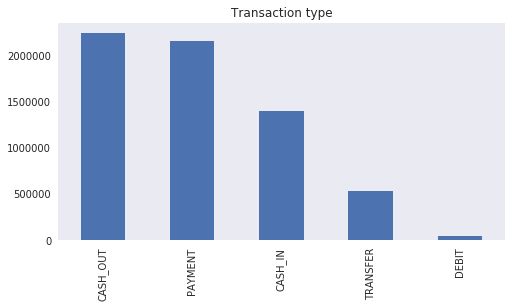

In [6]:
print(raw_data.type.value_counts())

f, ax = plt.subplots(1, 1, figsize=(8, 4))
raw_data.type.value_counts().plot(kind='bar', title="Transaction type", ax=ax, figsize=(8, 4))
plt.show()

There are 2 flags:  **isFraud** is the indicator which indicates the actual fraud transactions whereas **isFlaggedFraud** is what the system prevents the transaction due to internal thresholds being triggered.


Let's quickly what kinds of transaction are being flagged and are fraud...

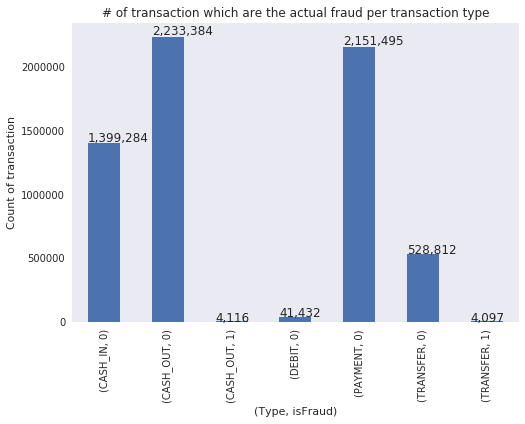

In [7]:
# isFraud
ax = raw_data.groupby(['type', 'isFraud']).size().plot(kind='bar')
ax.set_title("# of transaction which are the actual fraud per transaction type")
ax.set_xlabel("(Type, isFraud)")
ax.set_ylabel("Count of transaction")
for p in ax.patches:
    ax.annotate(str(format(int(p.get_height()), ',d')), (p.get_x(), p.get_height()*1.01))

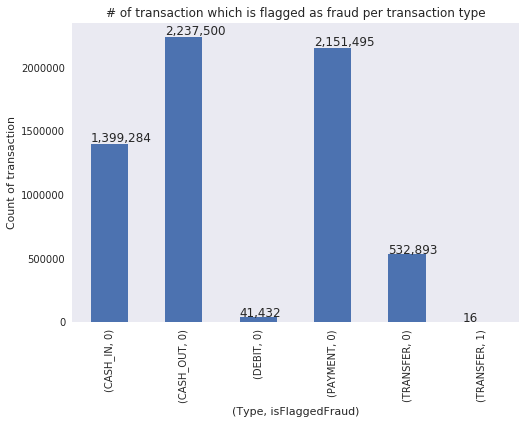

In [8]:
# isFlaggedFraud
ax = raw_data.groupby(['type', 'isFlaggedFraud']).size().plot(kind='bar')
ax.set_title("# of transaction which is flagged as fraud per transaction type")
ax.set_xlabel("(Type, isFlaggedFraud)")
ax.set_ylabel("Count of transaction")
for p in ax.patches:
    ax.annotate(str(format(int(p.get_height()), ',d')), (p.get_x(), p.get_height()*1.01))

So it looks the current IT system can flag only 16 transfer transactions as fraud. Let's look at those records and compare with the records which the system cannot catch them.


The plot below will also focus only on **transfer** transaction type.

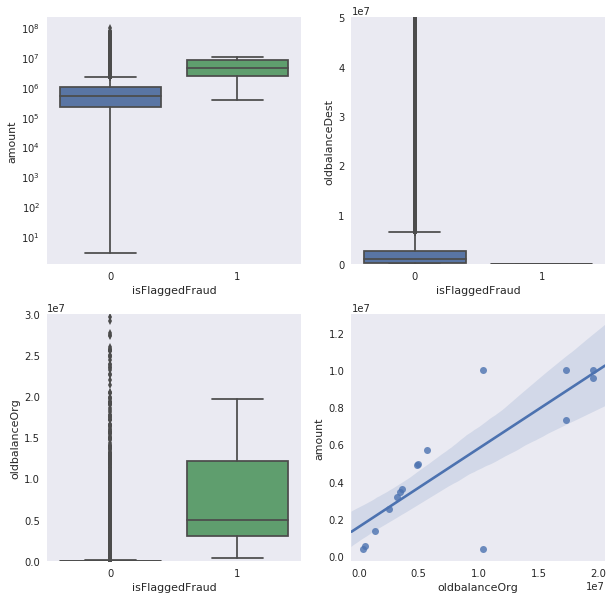

In [9]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
tmp = raw_data.loc[(raw_data.type == 'TRANSFER'), :]

a = sns.boxplot(x = 'isFlaggedFraud', y = 'amount', data = tmp, ax=axs[0][0])
axs[0][0].set_yscale('log')
b = sns.boxplot(x = 'isFlaggedFraud', y = 'oldbalanceDest', data = tmp, ax=axs[0][1])
axs[0][1].set(ylim=(0, 0.5e8))
c = sns.boxplot(x = 'isFlaggedFraud', y = 'oldbalanceOrg', data=tmp, ax=axs[1][0])
axs[1][0].set(ylim=(0, 3e7))
d = sns.regplot(x = 'oldbalanceOrg', y = 'amount', data=tmp.loc[(tmp.isFlaggedFraud ==1), :], ax=axs[1][1])
plt.show()

### 2. Modeling & Data Pre-processing
In this section, we will focus only **Transfer** and **Cash Out** transaction types, as they have been identified as fraud.

In [10]:
from statsmodels.tools import categorical

# 1. Keep only interested transaction type ('TRANSFER', 'CASH_OUT')
# 2. Drop some columns
# 3. Convert categorical variables to numeric variable
tmp = raw_data.loc[(raw_data['type'].isin(['TRANSFER', 'CASH_OUT'])),:]
tmp.drop(['step', 'nameOrig', 'nameDest', 'isFlaggedFraud'], axis=1, inplace=True)
tmp = tmp.reset_index(drop=True)
a = np.array(tmp['type'])
b = categorical(a, drop=True)
tmp['type_num'] = b.argmax(1)

tmp.head()

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,type_num
0,TRANSFER,181.00,181.0,0.0,0.0,0.00,1,1
1,CASH_OUT,181.00,181.0,0.0,21182.0,0.00,1,0
2,CASH_OUT,229133.94,15325.0,0.0,5083.0,51513.44,0,0
3,TRANSFER,215310.30,705.0,0.0,22425.0,0.00,0,1
4,TRANSFER,311685.89,10835.0,0.0,6267.0,2719172.89,0,1


Let's see the correlation of the selected datapoint from above.

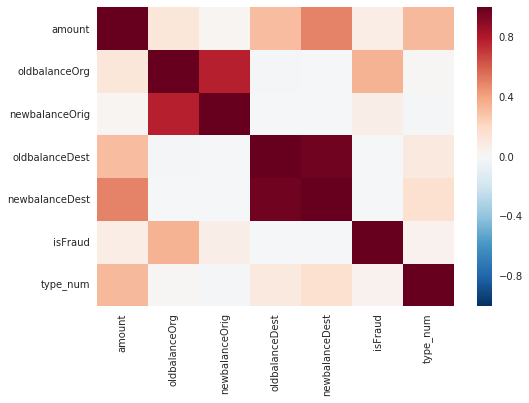

In [11]:
def correlation_plot(df):
    fig = plt.figure(figsize=(10, 10))
    ax1 = fig.add_subplot(111)
    cmap = cm.get_cmap('jet', 30)
    cax = ax1.imshow(df.corr(), interpolation = "nearest", cmap = cmap)
    ax1.grid(True)
    plt.title("Correlation Heatmap")
    labels = df.columns.tolist()
    ax1.set_xticklabels(labels, fontsize=13, rotation=45)
    ax1.set_yticklabels(labels, fontsize=13)
    fig.colorbar(cax)
    plt.show()
    
# correlation_plot(tmp)

# Alternatively, we can use quick seaborn
# plot the heatmap
sns.heatmap(tmp.corr())

Quickly get the count and the target variable count.

Total unber of transactions: 2770409


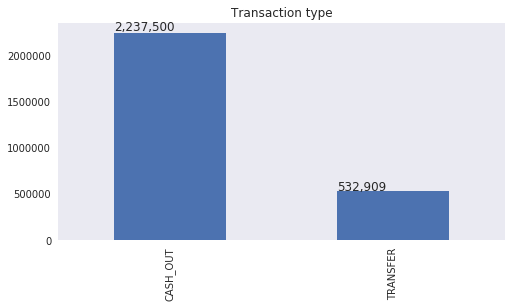

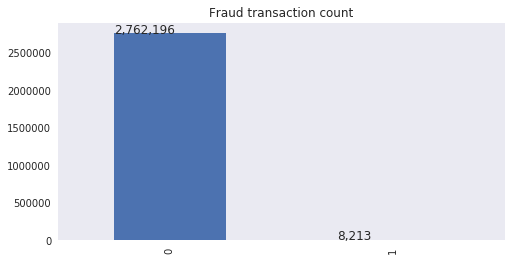

In [12]:
print('Total unber of transactions: %d' % len(tmp))

# print(pd.value_counts(tmp['isFraud']) / len(tmp))
# 0.99703545577566344897089202352432

ax = tmp.type.value_counts().plot(kind='bar', title="Transaction type", figsize=(8, 4))
for p in ax.patches:
    ax.annotate(str(format(int(p.get_height()), ',d')), (p.get_x(), p.get_height()*1.01))

plt.show()

ax = pd.value_counts(tmp['isFraud'], sort = True).sort_index().plot(kind='bar', title="Fraud transaction count", figsize=(8, 4))
for p in ax.patches:
    ax.annotate(str(format(int(p.get_height()), ',d')), (p.get_x(), p.get_height()))
    
plt.show()


Based on the dataset, the numeric variables are quite skew, in this case. Let's scale it with 2 methods and compare them on the graph.

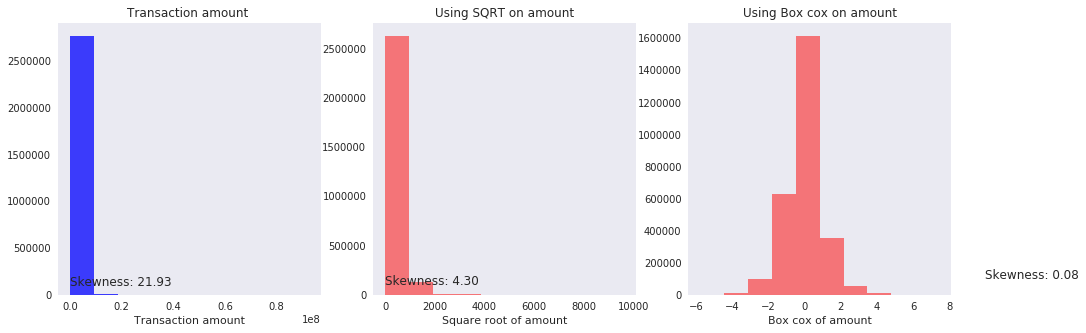

In [13]:
tmp['amount_boxcox'] = preprocessing.scale(boxcox(tmp['amount']+1)[0])

figure = plt.figure(figsize=(16, 5))
figure.add_subplot(131) 
plt.hist(tmp['amount'] ,facecolor='blue',alpha=0.75) 
plt.xlabel("Transaction amount") 
plt.title("Transaction amount ") 
plt.text(10,100000,"Skewness: {0:.2f}".format(skew(tmp['amount'])))

figure.add_subplot(132)
plt.hist(np.sqrt(tmp['amount']), facecolor = 'red', alpha=0.5)
plt.xlabel("Square root of amount")
plt.title("Using SQRT on amount")
plt.text(10, 100000, "Skewness: {0:.2f}".format(skew(np.sqrt(tmp['amount']))))

figure.add_subplot(133)
plt.hist(tmp['amount_boxcox'], facecolor = 'red', alpha=0.5)
plt.xlabel("Box cox of amount")
plt.title("Using Box cox on amount")
plt.text(10, 100000, "Skewness: {0:.2f}".format(skew(tmp['amount_boxcox'])))

plt.show()

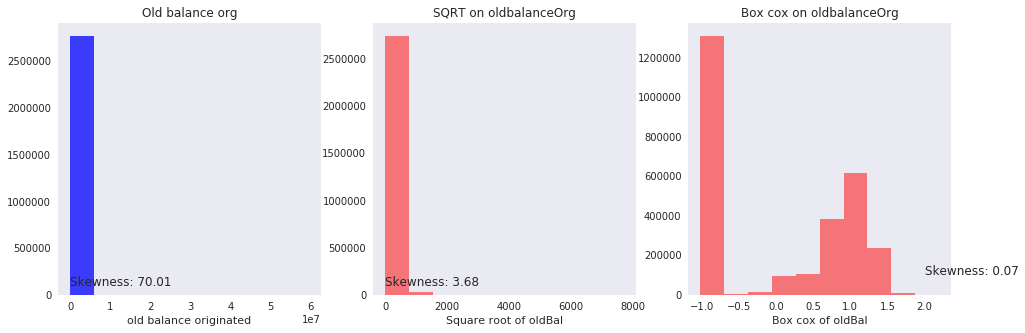

In [14]:
tmp['oldbalanceOrg_boxcox'] = preprocessing.scale(boxcox(tmp['oldbalanceOrg']+1)[0])

figure = plt.figure(figsize=(16, 5))
figure.add_subplot(131) 
plt.hist(tmp['oldbalanceOrg'] ,facecolor='blue',alpha=0.75) 
plt.xlabel("old balance originated") 
plt.title("Old balance org") 
plt.text(2,100000,"Skewness: {0:.2f}".format(skew(tmp['oldbalanceOrg'])))


figure.add_subplot(132)
plt.hist(np.sqrt(tmp['oldbalanceOrg']), facecolor = 'red', alpha=0.5)
plt.xlabel("Square root of oldBal")
plt.title("SQRT on oldbalanceOrg")
plt.text(2, 100000, "Skewness: {0:.2f}".format(skew(np.sqrt(tmp['oldbalanceOrg']))))

figure.add_subplot(133)
plt.hist(tmp['oldbalanceOrg_boxcox'], facecolor = 'red', alpha=0.5)
plt.xlabel("Box cox of oldBal")
plt.title("Box cox on oldbalanceOrg")
plt.text(2, 100000, "Skewness: {0:.2f}".format(skew(tmp['oldbalanceOrg_boxcox'])))

plt.show()


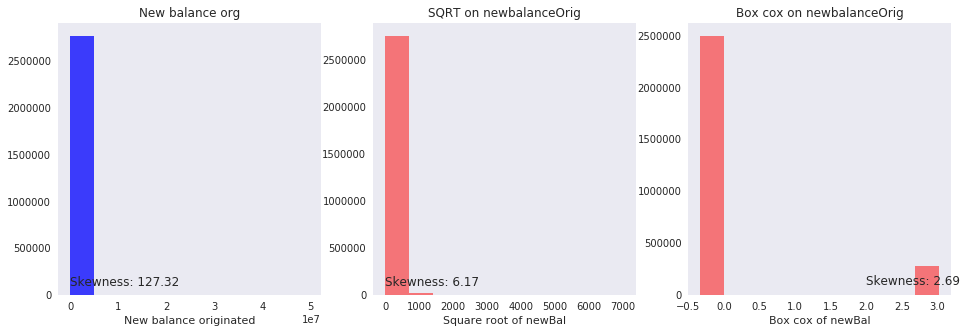

In [15]:
tmp['newbalanceOrg_boxcox'] = preprocessing.scale(boxcox(tmp['newbalanceOrig']+1)[0])

figure = plt.figure(figsize=(16, 5))
figure.add_subplot(131) 
plt.hist(tmp['newbalanceOrig'] ,facecolor='blue',alpha=0.75) 
plt.xlabel("New balance originated") 
plt.title("New balance org") 
plt.text(2,100000,"Skewness: {0:.2f}".format(skew(tmp['newbalanceOrig'])))


figure.add_subplot(132)
plt.hist(np.sqrt(tmp['newbalanceOrig']), facecolor = 'red', alpha=0.5)
plt.xlabel("Square root of newBal")
plt.title("SQRT on newbalanceOrig")
plt.text(2, 100000, "Skewness: {0:.2f}".format(skew(np.sqrt(tmp['newbalanceOrig']))))

figure.add_subplot(133)
plt.hist(tmp['newbalanceOrg_boxcox'], facecolor = 'red', alpha=0.5)
plt.xlabel("Box cox of newBal")
plt.title("Box cox on newbalanceOrig")
plt.text(2, 100000, "Skewness: {0:.2f}".format(skew(tmp['newbalanceOrg_boxcox'])))

plt.show()

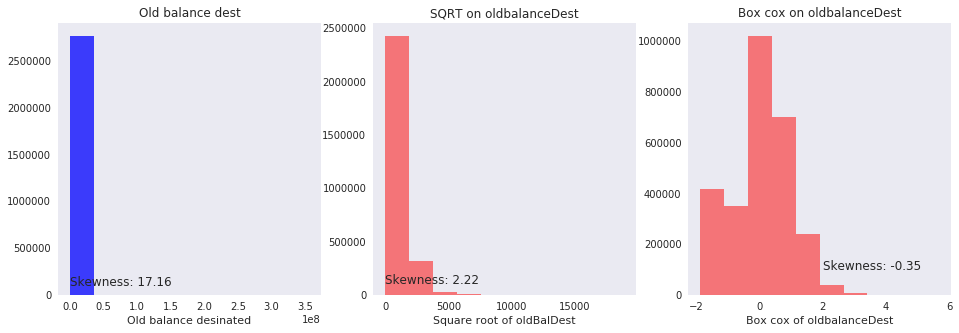

In [16]:
tmp['oldbalanceDest_boxcox'] = preprocessing.scale(boxcox(tmp['oldbalanceDest']+1)[0])

figure = plt.figure(figsize=(16, 5))
figure.add_subplot(131) 
plt.hist(tmp['oldbalanceDest'] ,facecolor='blue',alpha=0.75) 
plt.xlabel("Old balance desinated") 
plt.title("Old balance dest") 
plt.text(2,100000,"Skewness: {0:.2f}".format(skew(tmp['oldbalanceDest'])))


figure.add_subplot(132)
plt.hist(np.sqrt(tmp['oldbalanceDest']), facecolor = 'red', alpha=0.5)
plt.xlabel("Square root of oldBalDest")
plt.title("SQRT on oldbalanceDest")
plt.text(2, 100000, "Skewness: {0:.2f}".format(skew(np.sqrt(tmp['oldbalanceDest']))))

figure.add_subplot(133)
plt.hist(tmp['oldbalanceDest_boxcox'], facecolor = 'red', alpha=0.5)
plt.xlabel("Box cox of oldbalanceDest")
plt.title("Box cox on oldbalanceDest")
plt.text(2, 100000, "Skewness: {0:.2f}".format(skew(tmp['oldbalanceDest_boxcox'])))

plt.show()

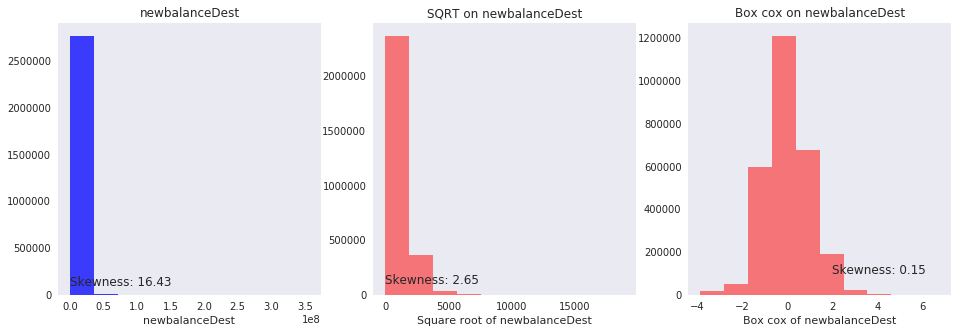

In [17]:
tmp['newbalanceDest_boxcox'] = preprocessing.scale(boxcox(tmp['newbalanceDest']+1)[0])

figure = plt.figure(figsize=(16, 5))
figure.add_subplot(131) 
plt.hist(tmp['newbalanceDest'] ,facecolor='blue',alpha=0.75) 
plt.xlabel("newbalanceDest") 
plt.title("newbalanceDest") 
plt.text(2,100000,"Skewness: {0:.2f}".format(skew(tmp['newbalanceDest'])))


figure.add_subplot(132)
plt.hist(np.sqrt(tmp['newbalanceDest']), facecolor = 'red', alpha=0.5)
plt.xlabel("Square root of newbalanceDest")
plt.title("SQRT on newbalanceDest")
plt.text(2, 100000, "Skewness: {0:.2f}".format(skew(np.sqrt(tmp['newbalanceDest']))))

figure.add_subplot(133)
plt.hist(tmp['newbalanceDest_boxcox'], facecolor = 'red', alpha=0.5)
plt.xlabel("Box cox of newbalanceDest")
plt.title("Box cox on newbalanceDest")
plt.text(2, 100000, "Skewness: {0:.2f}".format(skew(tmp['newbalanceDest_boxcox'])))

plt.show()

In [18]:
print("The fraud transaction of the filtered dataset: {0:.4f}%".format((len(tmp[tmp.isFraud == 1])/len(tmp)) * 100))

The fraud transaction of the filtered dataset: 0.2965%


We filtered unrelated transaction type out and keep only relevant. There're 0.3% actual fraud. This is very imbalance data.


We then use traditional under-sampling method (there are several other ways; under and over sampling, SMOTE, etc). Sample the dataset by creating a 50-50 ratio of randomly selecting 'x' amount of sample from majority class, with 'x' being the total number of records with the minority class.

In [19]:
tmp.drop(['oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'amount', 'type'], axis=1, inplace=True)

X = tmp.ix[:, tmp.columns != 'isFraud']
y = tmp.ix[:, tmp.columns == 'isFraud']

In [20]:
# Number of data points in the minority class
number_records_fraud = len(tmp[tmp.isFraud == 1])
fraud_indices = tmp[tmp.isFraud == 1].index.values

# Picking the indices of the normal classes
normal_indices = tmp[tmp.isFraud == 0].index

# Out of the indices we picked, randomly select "x" number (x - same as total fraud)
random_normal_indices = np.random.choice(normal_indices, number_records_fraud, replace = False)
random_normal_indices = np.array(random_normal_indices)

# Appending the 2 indices
under_sample_indices = np.concatenate([fraud_indices,random_normal_indices])
under_sample_data = tmp.iloc[under_sample_indices, :]

X_undersample = under_sample_data.ix[:, under_sample_data.columns != 'isFraud']
y_undersample = under_sample_data.ix[:, under_sample_data.columns == 'isFraud']

# Showing ratio
print("Percentage of normal transactions: ", len(under_sample_data[under_sample_data.isFraud == 0])/len(under_sample_data))
print("Percentage of fraud transactions: ", len(under_sample_data[under_sample_data.isFraud == 1])/len(under_sample_data))
print("Total number of transactions in resampled data: ", len(under_sample_data))

Percentage of normal transactions:  0.5
Percentage of fraud transactions:  0.5
Total number of transactions in resampled data:  16426


### 3. Machine Learning: Simple Logistic Regression Classifier

From the model evaluation (or confusion matrix), we know that

 1. Accuracy = (TP + TN) / Total

 2. Recall = TP / (TP + FN)

 3. Presicion = TP / (TP + FP)
  
 4. F Score = 2 ( Recall \* Presicion ) / ( Recall + Presicion )


We are interested in the recall score to capture the most fraudulent transactions. As we know, due to the imbalance of the data, many observations could be predicted as False Negatives (missed fraudulent transactions), being, that we predict a normal transaction, but it is in fact a fraudulent one. Recall captures this.


Obviously, trying to increase recall, tends to come with a decrease of precision. However, in our case, if we predict that a transaction is fraudulent and turns out not to be. These are False Positive (false alarms).


In [21]:
# Split dataset to taining set and test set randomly

# Whole dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

# print("Number transactions train dataset: ", format(len(X_train),',d'))
# print("Number transactions test dataset: ", format(len(X_test), ',d'))
# print("Total number of transactions: ", format(len(X_train)+len(X_test), ',d'))

# Undersampled dataset
X_train_undersample, X_test_undersample, y_train_undersample, y_test_undersample = train_test_split(X_undersample
                                                                                                   ,y_undersample
                                                                                                   ,test_size = 0.3
                                                                                                   ,random_state = 0)
print("")
print("Number transactions train dataset: ", format(len(X_train_undersample),',d'))
print("Number transactions test  dataset: ", format(len(X_test_undersample),',d'))
print("Total number of transactions     : ", format(len(X_train_undersample)+len(X_test_undersample),',d'))


Number transactions train dataset:  11,498
Number transactions test  dataset:  4,928
Total number of transactions     :  16,426


In [22]:
# inputs (predictors)
X_train_undersample.tail()

,type_num,amount_boxcox,oldbalanceOrg_boxcox,newbalanceOrg_boxcox,oldbalanceDest_boxcox,newbalanceDest_boxcox
2284187,0,-1.035339,-1.019720,-0.331128,1.077342,1.073748
598332,0,-2.081727,1.386068,3.020656,-1.873353,-2.249087
78016,0,0.956526,0.568238,-0.331128,-1.331427,-2.117901
2664096,1,1.427501,-1.019720,-0.331128,0.669534,0.774910
1398669,0,0.596818,1.378444,-0.331128,-0.932416,-0.625755


In [23]:
# target (to be predicted)
y_train_undersample.tail()

,isFraud
2284187,0
598332,0
78016,0
2664096,0
1398669,1


In [24]:
def printing_Kfold_scores(x_train_data, y_train_data, kfoldnum, c_array):
    # define K-Fold
    fold = KFold(len(y_train_data), kfoldnum, shuffle=False) 

    results_table = pd.DataFrame(index = range(len(c_array),4), 
                                 columns = ['C_parameter','Mean recall score', 'Mean precision score', 'F Score'])
    results_table['C_parameter'] = c_array

    # the k-fold will give 2 lists: train_indices = indices[0], test_indices = indices[1]
    j = 0
    for c_param in c_array:
        print('------------------------------------------------------------------------')
        print('Regularization Hyper-parameter (to prevent model overfitting): ', c_param)
        print('------------------------------------------------------------------------')
        print('')

        recall_accs = []
        precision_accs = []
        for iteration, indices in enumerate(fold,start=1):

            # Call the logistic regression model with a certain C parameter
            lr = LogisticRegression(C = c_param)
#             lr = LogisticRegression(C = c_param, penalty = 'l2')

            # Use the training data to fit the model. In this case, we use the portion of the fold to train the model
            # with indices[0]. We then predict on the portion assigned as the 'test cross validation' with indices[1]
            lr.fit(x_train_data.iloc[indices[0],:],y_train_data.iloc[indices[0],:].values.ravel())

            # Predict values using the test indices in the training data
            y_pred_undersample = lr.predict(x_train_data.iloc[indices[1],:].values)

            # Calculate the recall score and append it to a list for recall scores representing the current c_parameter
            recall_acc = recall_score(y_train_data.iloc[indices[1],:].values,y_pred_undersample)
            recall_accs.append(recall_acc)
            
            precision_acc = precision_score(y_train_data.iloc[indices[1], :].values, y_pred_undersample)
            precision_accs.append(precision_acc)
            print("K-Fold Iteration {}: recall = {:.4f}, precision = {:.4f}".format(iteration, recall_acc, precision_acc))

        # The mean value of those recall scores is the metric we want to save and get hold of.
        results_table.ix[j,'Mean recall score'] = np.mean(recall_accs)
        results_table.ix[j, 'Mean precision score'] = np.mean(precision_accs)
        results_table.ix[j, 'F Score'] = 2 * np.mean(recall_accs) * np.mean(precision_accs)/(np.mean(recall_accs)
                                                                                             + np.mean(precision_accs))
        j += 1
        print('')
        print('Mean recall score   : {:.4f}'.format(np.mean(recall_accs)))
        print('Mean precision score: {:.4f}'.format(np.mean(precision_accs)))
        print('F Score             : {:.4f}'.format( 2 * np.mean(recall_accs) * np.mean(precision_accs)
                                                    /(np.mean(recall_accs) + np.mean(precision_accs)) ))
        print('')

    best_c = results_table.loc[results_table['F Score'].idxmax()]['C_parameter']
    
    # Finally, we can check which C parameter is the best amongst the chosen.
    print('********************************************************************************************')
    print('Best model to choose from cross validation is with Regularization Hyper-parameter = ', best_c)
    print('********************************************************************************************')
    
    return best_c

In [25]:
c_param_range = [0.1, 1, 10, 100, 1000, 10000, 100000]
k_fold = 5
best_c = printing_Kfold_scores(X_train_undersample,y_train_undersample, k_fold, c_param_range)

------------------------------------------------------------------------
Regularization Hyper-parameter (to prevent model overfitting):  0.1
------------------------------------------------------------------------

K-Fold Iteration 1: recall = 0.9579, precision = 0.8822
K-Fold Iteration 2: recall = 0.9566, precision = 0.8866
K-Fold Iteration 3: recall = 0.9652, precision = 0.8657
K-Fold Iteration 4: recall = 0.9596, precision = 0.9019
K-Fold Iteration 5: recall = 0.9650, precision = 0.8795

Mean recall score   : 0.9609
Mean precision score: 0.8832
F Score             : 0.9204

------------------------------------------------------------------------
Regularization Hyper-parameter (to prevent model overfitting):  1
------------------------------------------------------------------------

K-Fold Iteration 1: recall = 0.9623, precision = 0.9082
K-Fold Iteration 2: recall = 0.9644, precision = 0.9197
K-Fold Iteration 3: recall = 0.9706, precision = 0.9075
K-Fold Iteration 4: recall = 0.9604

### 4. Evaluate Model Performance

In [26]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        1#print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Recall    in the testing dataset: 0.9594
Precision in the testing dataset: 0.9180


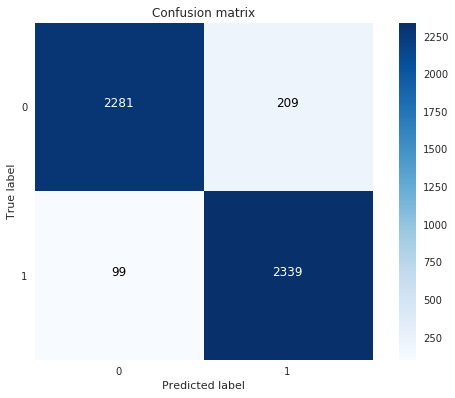

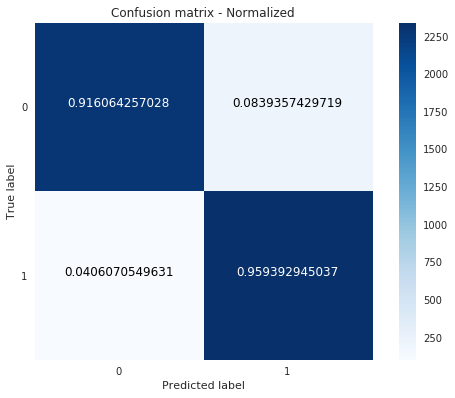

In [27]:
# Confusion matrix
lr = LogisticRegression(C = best_c)
lr.fit(X_train_undersample,y_train_undersample.values.ravel())
y_pred_undersample = lr.predict(X_test_undersample.values)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test_undersample,y_pred_undersample)

print("Recall    in the testing dataset: {0:.4f}".format(cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1])))
print("Precision in the testing dataset: {0:.4f}".format(cnf_matrix[1,1]/(cnf_matrix[0,1]+cnf_matrix[1,1])))

# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()

# Plot Normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , normalize=True
                      , title='Confusion matrix - Normalized')
plt.show()

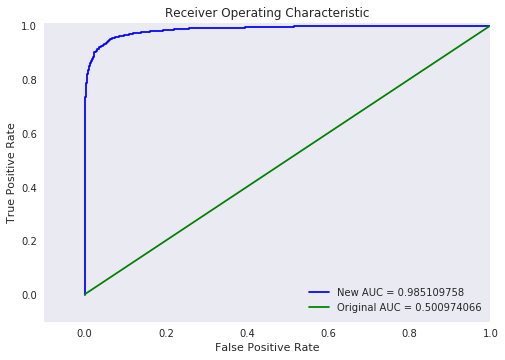

In [28]:
# ROC CURVE
lr = LogisticRegression(C = best_c)
y_pred_undersample_score = lr.fit(X_train_undersample,y_train_undersample.values.ravel()) \
                             .decision_function(X_test_undersample.values)

fpr, tpr, thresholds = roc_curve(y_test_undersample.values.ravel(),y_pred_undersample_score)
roc_auc = auc(fpr,tpr)
fpr_org, tpr_org, thresholds_org = roc_curve(raw_data.isFraud,raw_data.isFlaggedFraud)
roc_auc_org = auc(fpr_org,tpr_org)
# Plot ROC
plt.title('Receiver Operating Characteristic')
# plt.plot([0,1],[0,1],'r--')
plt.plot(fpr, tpr, 'b',label='New AUC = %0.9f'% roc_auc)
plt.plot(fpr_org, tpr_org, 'g',label='Original AUC = %0.9f'% roc_auc_org)
plt.legend(loc='best')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [29]:
print('How much degree the new model is better than the original model?')
print('Lift Score: {0:.02f} %'.format(100 * roc_auc / roc_auc_org))

How much degree the new model is better than the original model?
Lift Score: 196.64 %


### End of Analysis

June 2017


By: GU Zhan (Sam) [LinkedIn](https://sg.linkedin.com/in/zhan-gu-27a82823)

[SamIsITspecialist@gmail.com](SamIsITspecialist@gmail.com)


Copyright 2016-2017 Some Rights Reserved

---